## Useful codes and functions for Tutorial 3

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [4]:
df = pd.read_csv('dataset1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Value
0,2023-09-12,0.319383
1,2023-09-13,0.373839
2,2023-09-14,0.447583
3,2023-09-15,-0.252889
4,2023-09-16,-0.468198


In [9]:
#save value in a series
ts = df['Value']

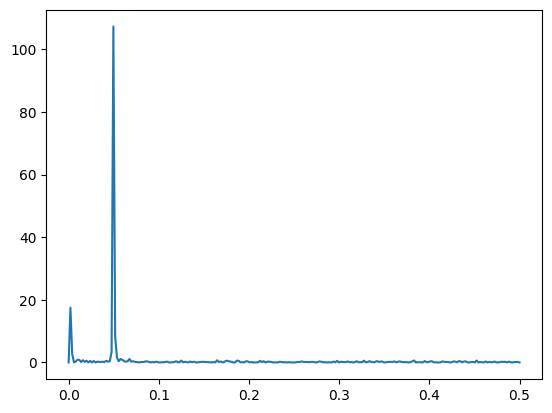

In [26]:
frequencies, power_spectrum = signal.periodogram(ts, fs=1)
plt.plot(frequencies, power_spectrum)

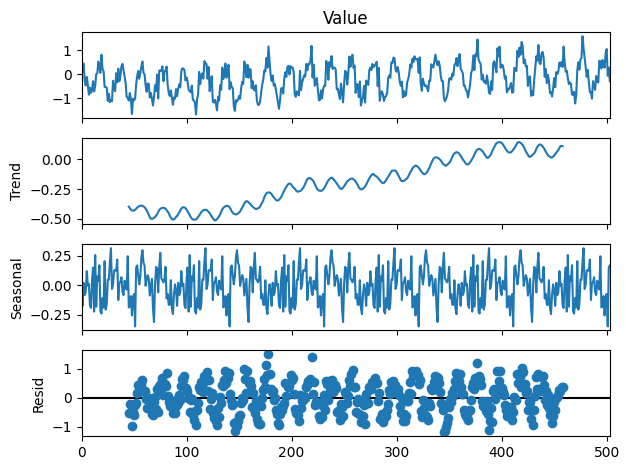

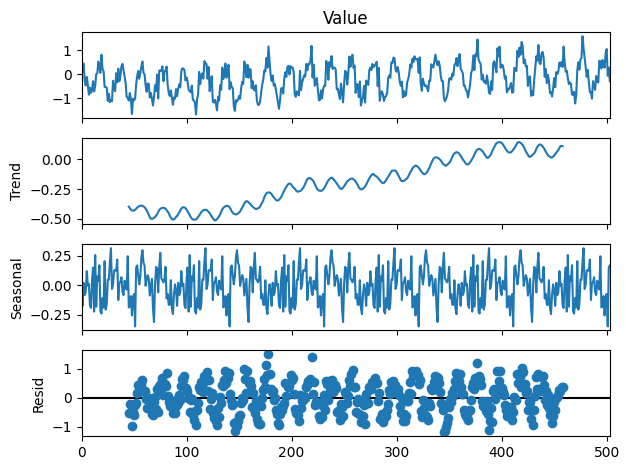

In [22]:
period = 90 # change as needed

result_season_trend = seasonal_decompose(ts, model='additive', period=period)
result_season_trend.plot()

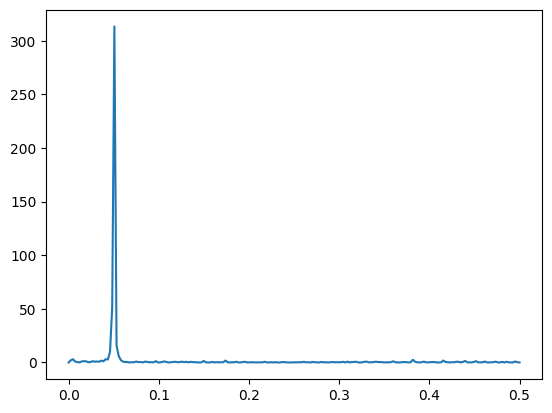

In [27]:
#ignore trend and statoinarize the data
ts_diff = ts.diff(periods=period)
ts_diff = ts_diff.dropna()

frequencies, power_spectrum = signal.periodogram(ts_diff, fs=1)
plt.plot(frequencies, power_spectrum)

In [39]:
import warnings
warnings.filterwarnings("ignore")

p_values = range(0, 5)
q_values = range(0, 5)

best_aic = float('inf')
best_order = None
best_model = None

for p in p_values:
    for q in q_values:
        try:
            model = ARIMA(ts_diff, order=(p, 0, q))
            model_fit = model.fit()
            # Compare AIC
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = (p, q)
                best_model = model_fit
        except:
            continue

print("Best (p,q):", best_order, " AIC:", best_aic)


Best (p,q): (2, 4)  AIC: 468.84900990822257


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  414
Model:                 ARIMA(2, 0, 4)   Log Likelihood                -226.425
Date:                Tue, 28 Jan 2025   AIC                            468.849
Time:                        12:49:59   BIC                            501.056
Sample:                             0   HQIC                           481.586
                                - 414                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0920      0.026      3.546      0.000       0.041       0.143
ar.L1          1.9019      0.000   9220.782      0.000       1.901       1.902
ar.L2         -1.0000      0.000  -7291.296      0.0

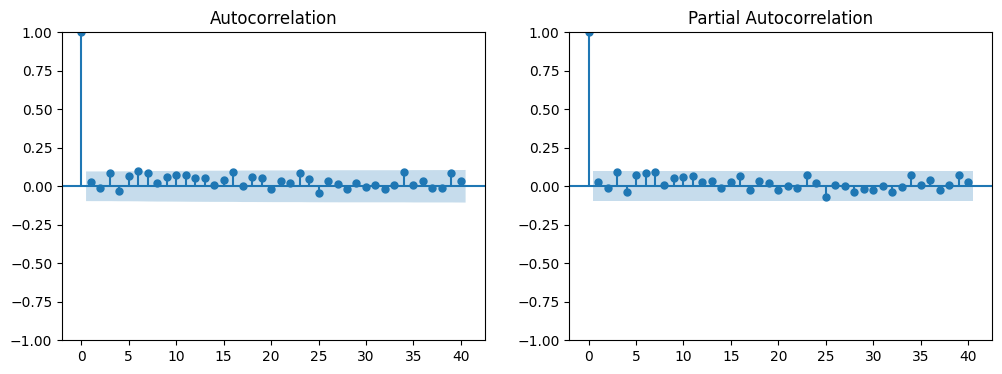

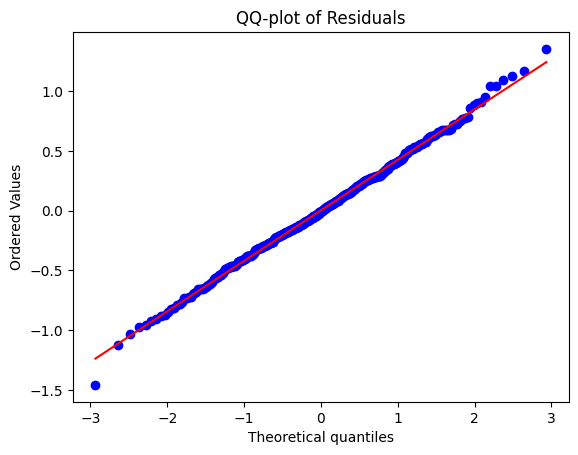

In [43]:
p_opt, q_opt = best_order
final_model = ARIMA(ts_diff, order=(p_opt, 0, q_opt)).fit()
print(final_model.summary())

# Inspect residuals
residuals = final_model.resid

fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(residuals, lags=40, ax=ax[0])
plot_pacf(residuals, lags=40, ax=ax[1])
plt.show()

# Quick normality check (optional)
import scipy.stats as st
st.probplot(residuals, plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()


In [ ]:
#confirm the residuals are white noise
#adf test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(residuals)
print("ADF Statistic: ", adf_result[0])
print("p-value: ", adf_result[1])


ADF Statistic:  -5.8575018008013915
p-value:  3.4722440848248395e-07


In [47]:
#predict the future based on seasona
n = 90
forecast = final_model.forecast(steps=n)
forecast = forecast + ts[-period] # add last value of the original series
forecast.index = pd.date_range(start=ts.index[-1], periods=n, freq='D')

plt.plot(ts, label='Original')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()


KeyError: -90